## Notebook Purpose
This notebook is used to compute and plot bin-wise debris-cover and ice cliff statistics (Section 6.6, Figure 8, and Table 4).  

#### Last updated: August 16, 2023

## TODO:
- Update imports when new library has been built up with all updates
-Generalise path to data products during revisions, after the data distribution plan is finalized


In [1]:
%load_ext autoreload
%autoreload 2
%config InlineBackend.figure_format='retina'

In [2]:
import numpy as np 
import geopandas as gpd
import matplotlib.pyplot as plt
from imview import pltlib
import pandas as pd
from pygeotools.lib import warplib,geolib,iolib,malib,filtlib,timelib
import os,sys,glob,shutil
from velocity_proc import glac_dyn, constants, velocity_filter, velocity_timeseries

/swbuild/sbhusha1/miniconda3/envs/bhushanGDAL3/lib/python3.9/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [3]:
%matplotlib inline

In [4]:
def melt_summary_function(melt_df):
    
    mask = melt_df['med_bg_dhdt'] > 0
    enhancement_factor = melt_df['med_hotspot_dhdt']/melt_df['med_bg_dhdt']
    melt_debris_total = ((melt_df['med_bg_dhdt'] * melt_df['area_bg']) + (melt_df['med_hotspot_dhdt'] * melt_df['area_hotspot']))/(melt_df['area_bg'] + melt_df['area_hotspot'])
    melt_by_icecliff = melt_debris_total-melt_df['med_bg_dhdt']
    melt_contribution = melt_by_icecliff/(melt_debris_total)
    #melt_contribution2 = (melt_df['med_hotspot_dhdt']*melt_df['area_hotspot'])/(melt_debris_total*(melt_df['area_bg'] + melt_df['area_hotspot']))
    ice_cliff_area = ((melt_df.area_hotspot)/(melt_df.area_bg+melt_df.area_hotspot))*100
    # create mask to restrict analysis to bins where debris is also melting
    melt_contribution[mask] = np.nan
    enhancement_factor[mask] = np.nan
    #ice_cliff_area[mask] = np.nan
    melt_df['melt_debris_total'] = melt_debris_total
    melt_df['ice_cliff_area_perc'] = ice_cliff_area
    melt_df['ice_cliff_melt_contribution'] = melt_contribution * 100
    #melt_df['ice_cliff_melt_contribution2'] = melt_contribution2 * 100
    melt_df['ice_cliff_enhancement_factor'] = enhancement_factor 
    
    return melt_df

In [5]:
%cd /nobackup/sbhusha1/chapter2/

/nobackupp11/sbhusha1/chapter2


## Figure 8: Bin-wise ice cliff ablation distribution

In [9]:
imja_stats = pd.read_csv('imja/20230223/imja_farinotti_2015-10-02_to_2016-10-29_lag_smb_products/imja_farinotti_2015-10-02_to_2016-10-29_altitudnal_meltstats.csv')
khumbu_stats = pd.read_csv('changrinup/20230217/khumbu_farinotti_2015-11-02_to_2016-10-25_lag_smb_products/khumbu_farinotti_2015-11-02_to_2016-10-25_altitudnal_meltstats.csv')
black_changri_stats = pd.read_csv('changrinup/20230217/black_changri_nup_2015-11-02_to_2016-10-25_lag_smb_products/black_changri_nup_2015-11-02_to_2016-10-25_altitudnal_meltstats.csv')
ngozumpa_stats = pd.read_csv('ngozumpa/20230217/ngozumpa_farinotti_2012-12-23_to_2015-01-15_lag_smb_products/ngozumpa_farinotti_2012-12-23_to_2015-01-15_altitudnal_meltstats.csv')
langtang_stats = pd.read_csv('langtang/20230223/langtang_farinotti_2015-02-22_to_2016-01-07_lag_smb_products/langtang_farinotti_2015-02-22_to_2016-01-07_altitudnal_meltstats.csv')
lirung_stats = pd.read_csv('lirung/202320218/lirung_farinotti_2016-11-06_to_2017-12-22_lag_smb_products/lirung_farinotti_2016-11-06_to_2017-12-22_altitudnal_meltstats.csv')

## compute_icecliff_summary
imja_stats = melt_summary_function(imja_stats)
khumbu_stats = melt_summary_function(khumbu_stats)
black_changri_stats = melt_summary_function(black_changri_stats)
ngozumpa_stats = melt_summary_function(ngozumpa_stats)
langtang_stats = melt_summary_function(langtang_stats)
lirung_stats = melt_summary_function(lirung_stats)

In [10]:
# from here: https://stackoverflow.com/questions/4971269/how-to-pick-a-new-color-for-each-plotted-line-within-a-figure-in-matplotlib
from matplotlib.cm import get_cmap

name = "Accent"
cmap = get_cmap(name)  # type: matplotlib.colors.ListedColormap
colors = cmap.colors  # type: list


/tmp/ipykernel_17598/1831412491.py:5: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  cmap = get_cmap(name)  # type: matplotlib.colors.ListedColormap


In [11]:
glac_name = ['Lhotse Shar Imja', 'Khumbu', 'Black Changri Nup', 'Ngozumpa', 'Langtang', 'Lirung']

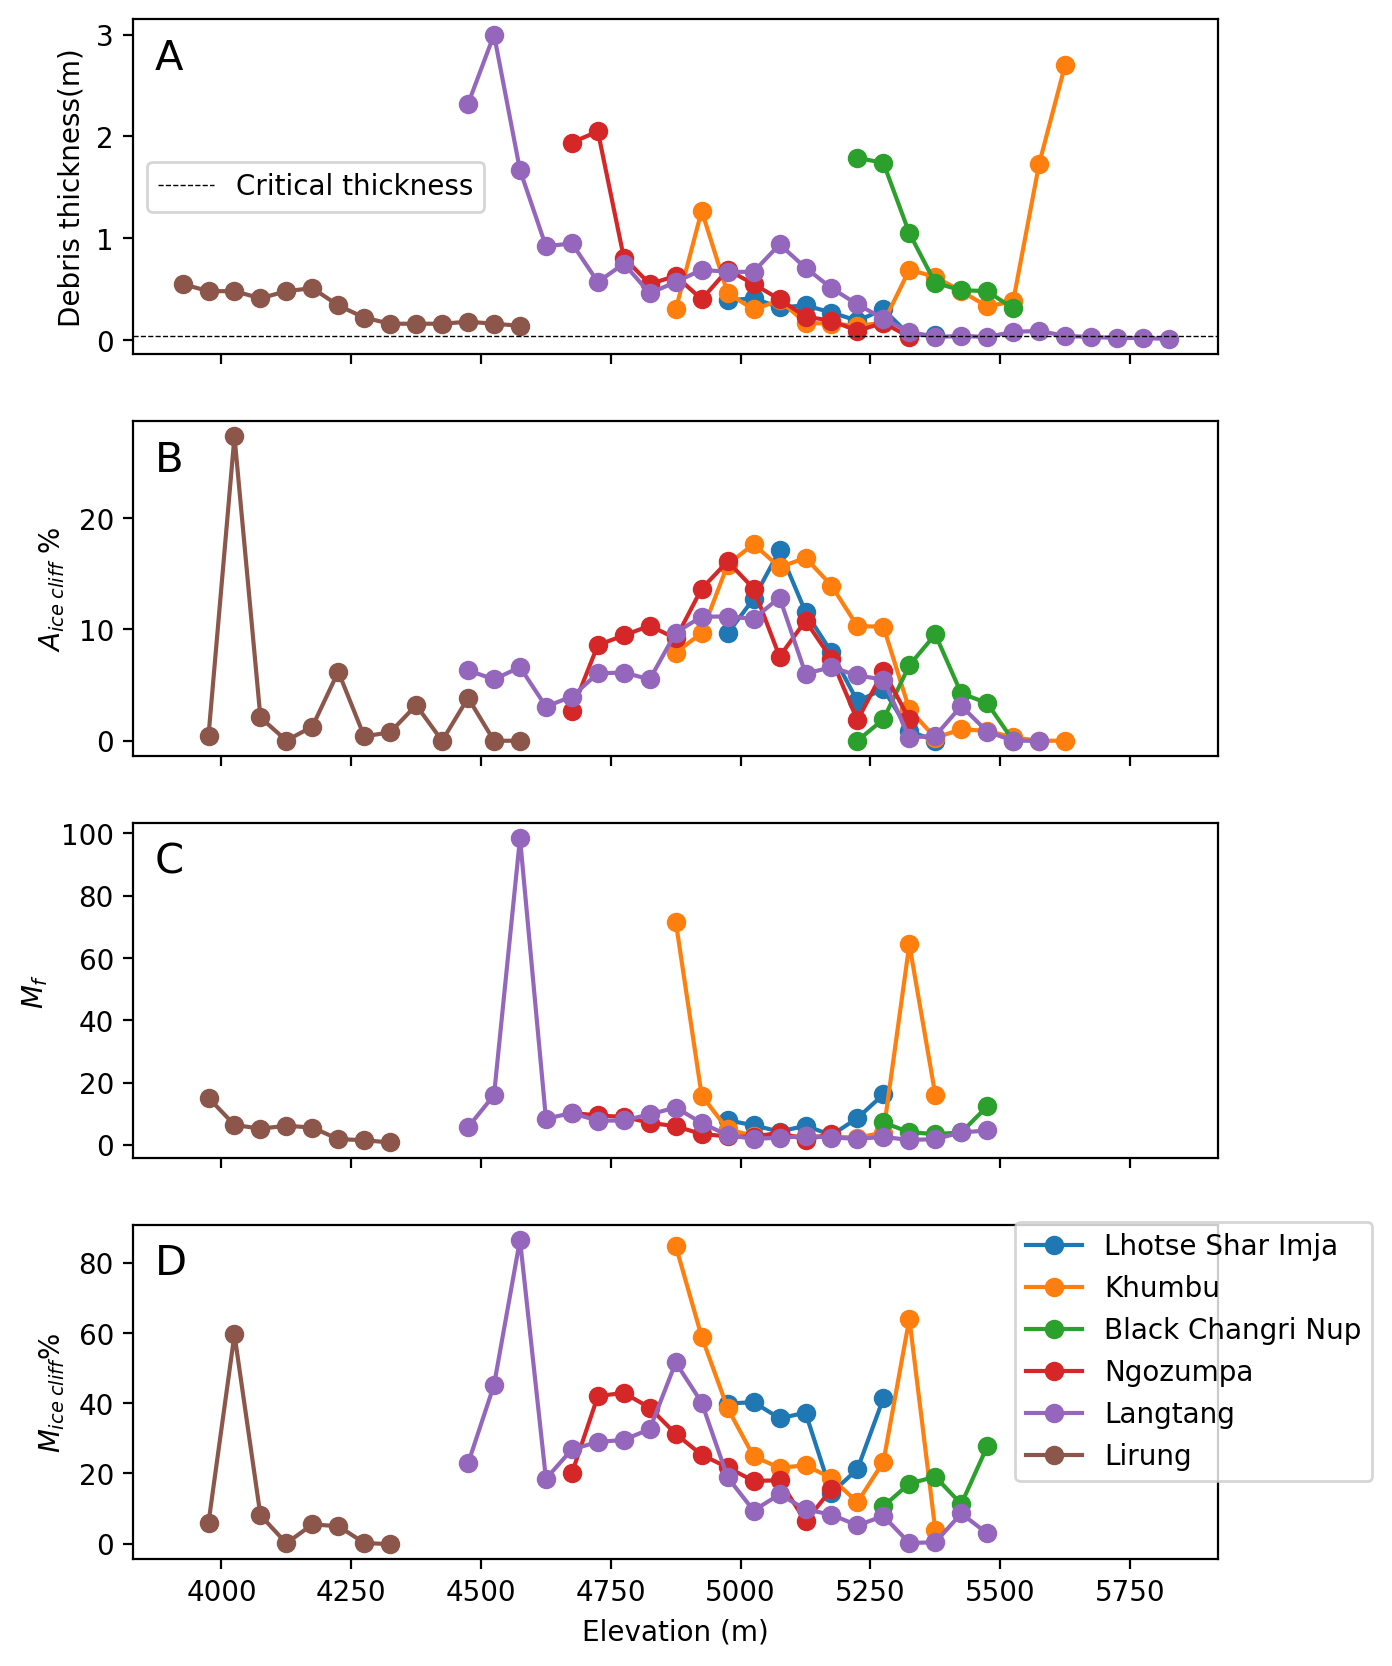

In [28]:
stats_df_list = [imja_stats,khumbu_stats,black_changri_stats,ngozumpa_stats,langtang_stats,lirung_stats]
f,ax = plt.subplots(4,1,sharex=True,figsize=(7,10))
## first columnt contains enhancement factor
for idx in range(len(glac_name)):
    ax[0].plot(stats_df_list[idx].z_bin_centers,stats_df_list[idx].med_deb_thick, marker='o')
    
    
    ax[1].plot(stats_df_list[idx].z_bin_centers,stats_df_list[idx].ice_cliff_area_perc,label=glac_name[idx], marker='o')
    ax[2].plot(stats_df_list[idx].z_bin_centers,stats_df_list[idx].ice_cliff_enhancement_factor,label=glac_name[idx], marker='o')
    
    ax[3].plot(stats_df_list[idx].z_bin_centers,stats_df_list[idx].ice_cliff_melt_contribution,label=glac_name[idx], marker='o')
    
    #ax[3].legend()
    
    ax[3].set_xlabel('Elevation (m)')
    ax[0].set_ylabel('Debris thickness(m)')
    ax[1].set_ylabel(r'$A_{{ice \;  cliff}}$ %')
    ax[2].set_ylabel(r'$M_{f}$')
    ax[3].set_ylabel(r'$M_{ice \; cliff}}$%')
   
    
ax[0].axhline(y=0.04,linewidth=0.5,linestyle='--',c='k',label='Critical thickness')
ax[0].legend()
ax[3].legend(bbox_to_anchor=(0.8, 1.05))
for axa in ax.ravel():
    axa.set_prop_cycle(color=colors)
    
ax[0].text(0.020,0.85,'A',
    color='k', fontsize=15,transform=ax[0].transAxes)
ax[1].text(0.020,0.85,'B',
    color='k', fontsize=15,transform=ax[1].transAxes)
ax[2].text(0.020,0.85,'C',
    color='k', fontsize=15,transform=ax[2].transAxes)
ax[3].text(0.020,0.85,'D',
    color='k', fontsize=15,transform=ax[3].transAxes)
#ax[4].text(0.020,0.92,'E',
 #   color='white', fontsize=15,transform=ax[4].transAxes)
    
plt.savefig('figures/Debris_ice_cliff_melt_summary.png',dpi=300,bbox_inches='tight',pad_inches=0.1)

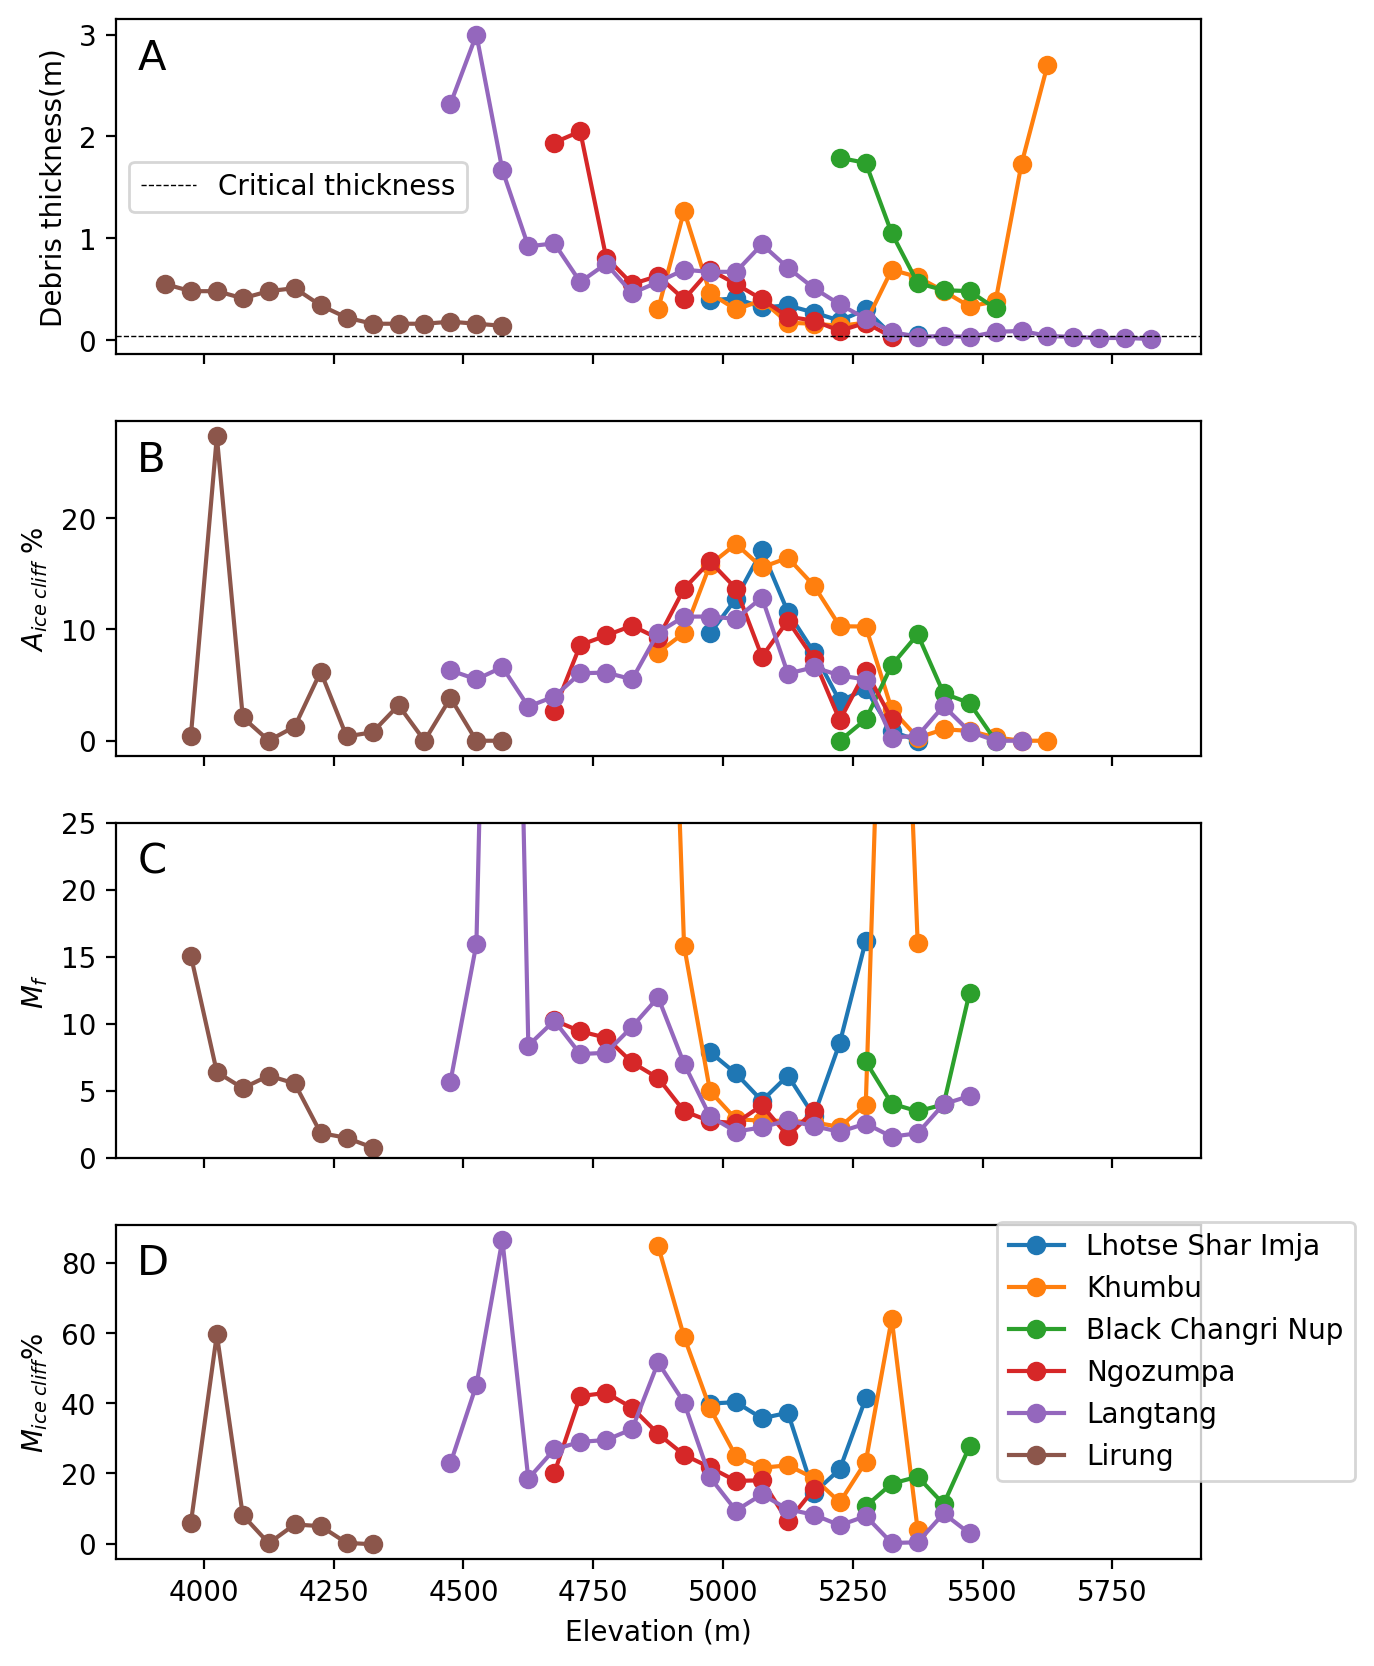

In [29]:
stats_df_list = [imja_stats,khumbu_stats,black_changri_stats,ngozumpa_stats,langtang_stats,lirung_stats]
f,ax = plt.subplots(4,1,sharex=True,figsize=(7,10))
## first columnt contains enhancement factor
for idx in range(len(glac_name)):
    ax[0].plot(stats_df_list[idx].z_bin_centers,stats_df_list[idx].med_deb_thick, marker='o')
    
    
    ax[1].plot(stats_df_list[idx].z_bin_centers,stats_df_list[idx].ice_cliff_area_perc,label=glac_name[idx], marker='o')
    ax[2].plot(stats_df_list[idx].z_bin_centers,stats_df_list[idx].ice_cliff_enhancement_factor,label=glac_name[idx], marker='o')
    
    ax[3].plot(stats_df_list[idx].z_bin_centers,stats_df_list[idx].ice_cliff_melt_contribution,label=glac_name[idx], marker='o')
    
    #ax[3].legend()
    
    ax[3].set_xlabel('Elevation (m)')
    ax[0].set_ylabel('Debris thickness(m)')
    
    ax[1].set_ylabel(r'$A_{{ice \;  cliff}}$ %')
    ax[2].set_ylabel(r'$M_{f}$')
    ax[2].set_ylim(0,25)
    ax[3].set_ylabel(r'$M_{ice \; cliff}}$%')
   
    
ax[0].axhline(y=0.04,linewidth=0.5,linestyle='--',c='k',label='Critical thickness')
ax[0].legend()
ax[3].legend(bbox_to_anchor=(0.8, 1.05))
for axa in ax.ravel():
    axa.set_prop_cycle(color=colors)
    
ax[0].text(0.020,0.85,'A',
    color='k', fontsize=15,transform=ax[0].transAxes)
ax[1].text(0.020,0.85,'B',
    color='k', fontsize=15,transform=ax[1].transAxes)
ax[2].text(0.020,0.85,'C',
    color='k', fontsize=15,transform=ax[2].transAxes)
ax[3].text(0.020,0.85,'D',
    color='k', fontsize=15,transform=ax[3].transAxes)
#ax[4].text(0.020,0.92,'E',
 #   color='white', fontsize=15,transform=ax[4].transAxes)
    
plt.savefig('figures/Debris_ice_cliff_melt_summary_clim_mf.png',dpi=300,bbox_inches='tight',pad_inches=0.1)

In [19]:
xlimit = ax[0].get_xlim()

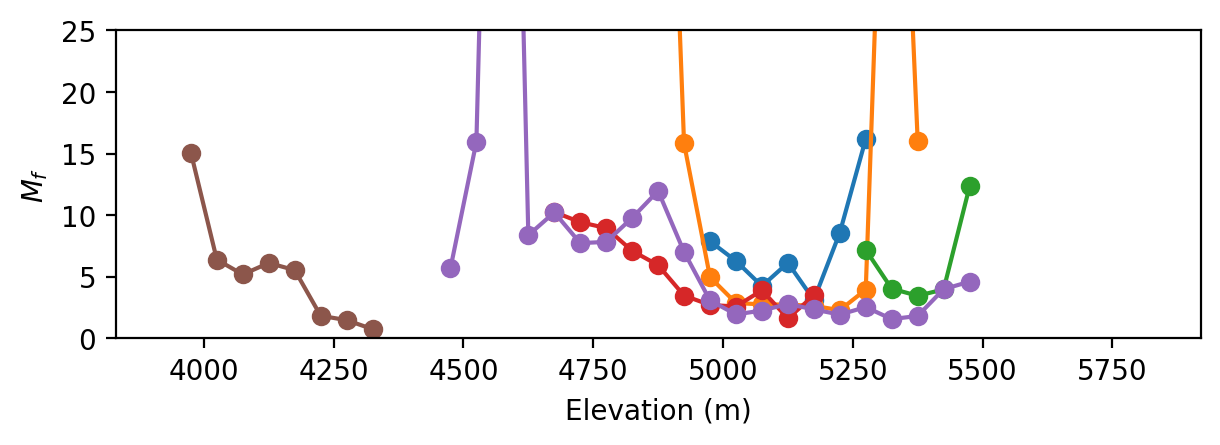

In [26]:
f,ax = plt.subplots(figsize=(7,2))
for idx in range(len(glac_name)):
    ax.plot(stats_df_list[idx].z_bin_centers,stats_df_list[idx].ice_cliff_enhancement_factor,label=glac_name[idx], marker='o')
ax.set_ylim(0,25)
ax.set_xlim(xlimit)
ax.set_xlabel('Elevation (m)')
ax.set_ylabel(r'$M_{f}$')
f.savefig('figures/meltenhancement_summary.png',dpi=300,bbox_inches='tight',pad_inches=0.1)

## Table 4: Consolidated melt contribution

In [9]:
def glacier_wide_ice_cliff_melt_contribution(df):
    total_glacier_debris_melt = (df['melt_debris_total']*(df['area_bg']*df['area_hotspot'])).sum()/((df['area_bg']*df['area_hotspot']).sum())
    total_glacier_bg_melt = (df['med_bg_dhdt']*df['area_bg']).sum()/(df['area_bg'].sum())
    return ((total_glacier_debris_melt - total_glacier_bg_melt)/total_glacier_debris_melt)*100

In [12]:
langtang_stats.area_hotspot.sum()

1.0714439999999994

In [10]:
glac_stats_list = [imja_stats,khumbu_stats,black_changri_stats,ngozumpa_stats,langtang_stats,lirung_stats]

In [13]:
consolidated_relative_cliff_area_list = []
total_ice_cliff_area_list = []
consolidated_relative_cliff_melt_contribution_list = []
for idx,glac_df in enumerate(glac_stats_list):
    consolidated_relative_cliff_area_list.append(
        ((glac_df.area_hotspot.sum())/(glac_df.area_hotspot.sum()+glac_df.area_bg.sum()))*100)
    consolidated_relative_cliff_melt_contribution_list.append(
        glacier_wide_ice_cliff_melt_contribution(glac_df))
    total_ice_cliff_area_list.append(glac_df['area_hotspot'].sum())

consolidated_melt_df = pd.DataFrame({'glacier':glac_name,'area_ice_cliff_km2':total_ice_cliff_area_list,'area_ice_cliff_perc':consolidated_relative_cliff_area_list,
                                     'ice_cliff_contribution_rel._debris':consolidated_relative_cliff_melt_contribution_list})
consolidated_melt_df

,glacier,area_ice_cliff_km2,area_ice_cliff_perc,ice_cliff_contribution_rel._debris
0,Lhotse Shar Imja,0.424592,9.538555,42.486945
1,Khumbu,0.776732,11.512960,39.673336
2,Black Changri Nup,0.068552,5.985736,28.623925
3,Ngozumpa,1.641132,9.766476,35.140526
4,Langtang,1.071444,6.892558,24.055409
5,Lirung,0.045724,3.641026,16.907137


## Old, exploratory

In [43]:
(langtang_stats.area_hotspot.sum())/(langtang_stats.area_hotspot.sum()+langtang_stats.area_bg.sum())*100

6.89255796419928

In [44]:
(lirung_stats.area_hotspot.sum())/(lirung_stats.area_hotspot.sum()+lirung_stats.area_bg.sum())*100

3.6410256410256268

In [45]:
(ngozumpa_stats.area_hotspot.sum())/(ngozumpa_stats.area_hotspot.sum()+ngozumpa_stats.area_bg.sum())*100

9.7664756296936

In [46]:
(black_changri_stats.area_hotspot.sum())/(black_changri_stats.area_hotspot.sum()+black_changri_stats.area_bg.sum())*100

5.9857359402613675

In [47]:
(khumbu_stats.area_hotspot.sum())/(khumbu_stats.area_hotspot.sum()+khumbu_stats.area_bg.sum())*100

11.512960328984068

In [48]:
(imja_stats.area_hotspot.sum())/(imja_stats.area_hotspot.sum()+imja_stats.area_bg.sum())*100

9.5385552702971

In [30]:
langtang_stats.keys()

Index(['med_bg_dhdt', 'nmad_bg_dhdt', 'q1_bg_dhdt', 'q3_bg_dhdt', 'area_bg',
       'med_hotspot_dhdt', 'nmad_hotspot_dhdt', 'q1_hotspot_dhdt',
       'q3_hotspot_dhdt', 'area_hotspot', 'med_clean_dhdt', 'nmad_clean_dhdt',
       'q1_clean_dhdt', 'q3_clean_dhdt', 'area_clean', 'med_total_dhdt',
       'nmad_total_dhdt', 'q1_total_dhdt', 'q3_total_dhdt', 'area_total',
       'med_deb_thick', 'nmad_deb_thick', 'q1_deb_thick', 'q3_deb_thick',
       'med_vm', 'nmad_vm', 'q1_vm', 'q3_vm', 'z_area', 'z_bin_centers',
       'melt_debris_total', 'ice_cliff_area_perc',
       'ice_cliff_melt_contribution', 'ice_cliff_enhancement_factor'],
      dtype='object')

In [41]:
glacier_wide_ice_cliff_melt_contribution(ngozumpa_stats)

35.140526470486435

In [10]:
glacier_wide_ice_cliff_melt_contribution(langtang_stats)

24.055409243111924

In [11]:
glacier_wide_ice_cliff_melt_contribution(lirung_stats)

16.90713675534153

In [12]:
glacier_wide_ice_cliff_melt_contribution(black_changri_stats)

28.623924744308617

In [13]:
glacier_wide_ice_cliff_melt_contribution(khumbu_stats)

39.67333600960018

In [14]:
glacier_wide_ice_cliff_melt_contribution(imja_stats)

42.48694522043065

In [15]:
total_glaicer_debris_melt = (ngozumpa_stats['melt_debris_total']*(ngozumpa_stats['area_bg']+ngozumpa_stats['area_hotspot'])).sum()

In [16]:
total_glacier_bg_melt = (ngozumpa_stats['med_bg_dhdt']*ngozumpa_stats['area_bg']).sum()

In [17]:
(total_glaicer_debris_melt - total_glacier_bg_melt)/(total_glacier_bg_melt)

0.4748308760189723

In [23]:
(ngozumpa_stats.area_hotspot.sum())/(ngozumpa_stats.area_hotspot.sum()+ngozumpa_stats.area_bg.sum())*100

9.7664756296936

In [24]:
(black_changri_stats.area_hotspot.sum())/(black_changri_stats.area_hotspot.sum()+black_changri_stats.area_bg.sum())*100

5.9857359402613675

In [25]:
(khumbu_stats.area_hotspot.sum())/(khumbu_stats.area_hotspot.sum()+khumbu_stats.area_bg.sum())*100

11.512960328984068

In [26]:
(imja_stats.area_hotspot.sum())/(imja_stats.area_hotspot.sum()+imja_stats.area_bg.sum())*100

9.5385552702971

In [27]:
(lirung_stats.area_hotspot.sum())/(lirung_stats.area_hotspot.sum()+lirung_stats.area_bg.sum())*100

3.6410256410256268

In [28]:
lirung_stats['area_hotspot']

0     0.000000
1     0.000740
2     0.018872
3     0.002808
4     0.000024
5     0.001852
6     0.019800
7     0.000856
8     0.000276
9     0.000188
10    0.000000
11    0.000308
12    0.000000
13    0.000000
Name: area_hotspot, dtype: float64

In [11]:
lirung_stats.iloc[2].med_hotspot_dhdt*lirung_stats.iloc[2].area_hotspot

-0.13509632

In [12]:
(lirung_stats.iloc[2].med_bg_dhdt*lirung_stats.iloc[2].area_bg+lirung_stats.iloc[2].med_hotspot_dhdt*lirung_stats.iloc[2].area_hotspot)/(lirung_stats.iloc[2].area_hotspot+lirung_stats.iloc[2].area_bg)

-2.8569717455364882

In [13]:
lirung_stats.iloc[2].med_hotspot_dhdt

-6.32

In [14]:
(lirung_stats.iloc[2].med_hotspot_dhdt*lirung_stats.iloc[2].area_hotspot+lirung_stats.iloc[2].med_bg_dhdt*lirung_stats.iloc[2].area_bg)/(med_bg_dhdt*lirung_stats.iloc[2].area_bg+med_bg_dhdt*lirung_stats.iloc[2].area_hotspot)

NameError: name 'med_bg_dhdt' is not defined

In [15]:
lirung_stats['area_bg']

0     0.000000
1     0.164640
2     0.047852
3     0.129504
4     0.138720
5     0.143312
6     0.301824
7     0.218980
8     0.036380
9     0.006128
10    0.008596
11    0.008528
12    0.004760
13    0.000140
Name: area_bg, dtype: float64

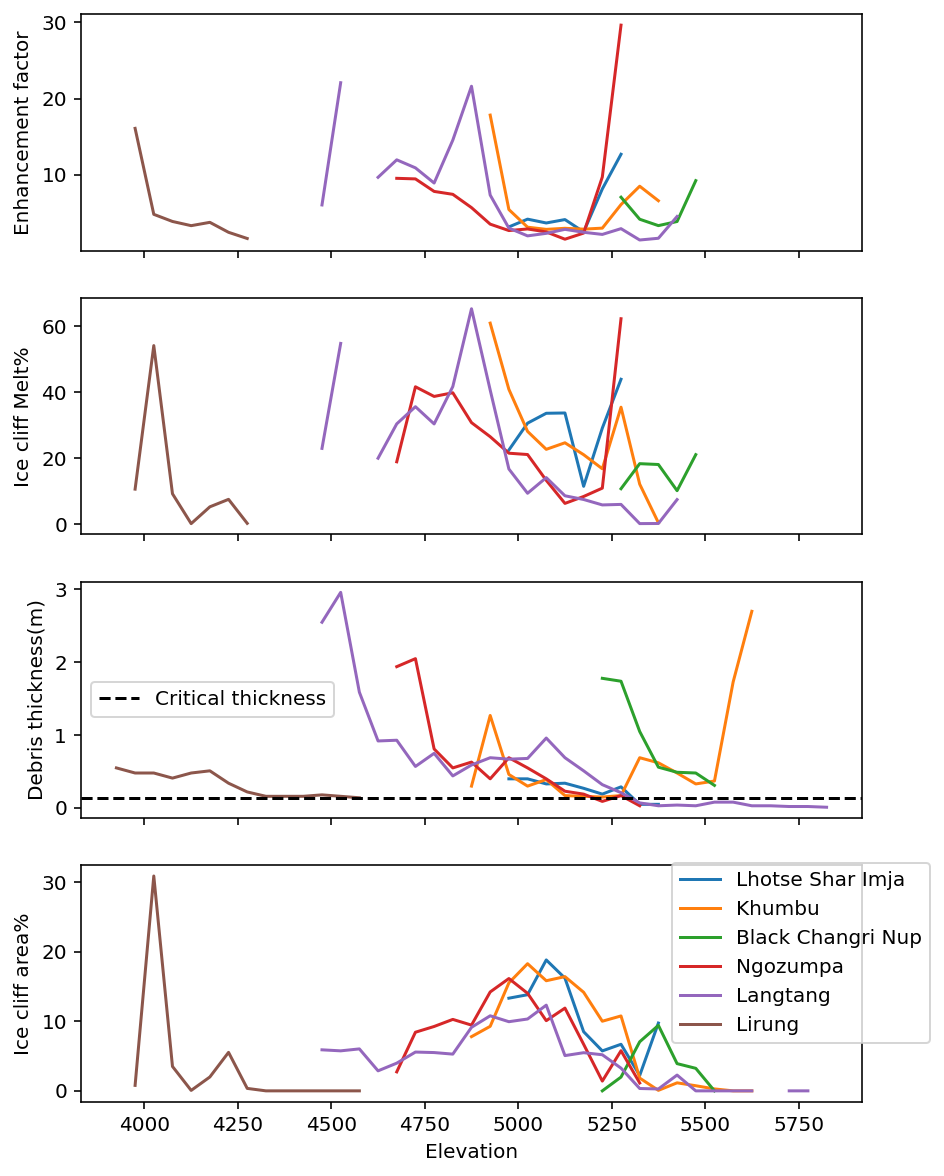

In [16]:
stats_df_list = [imja_stats,khumbu_stats,black_changri_stats,ngozumpa_stats,langtang_stats,lirung_stats]
f,ax = plt.subplots(4,1,sharex=True,figsize=(7,10))
## first columnt contains enhancement factor
for idx in range(len(glac_name)):
    ax[0].plot(stats_df_list[idx].z_bin_centers,stats_df_list[idx].ice_cliff_enhancement_factor,label=glac_name[idx])
    
    ax[1].plot(stats_df_list[idx].z_bin_centers,stats_df_list[idx].ice_cliff_melt_contribution,label=glac_name[idx])
    ax[2].plot(stats_df_list[idx].z_bin_centers,stats_df_list[idx].med_deb_thick)
    
    
    ax[3].plot(stats_df_list[idx].z_bin_centers,stats_df_list[idx].ice_cliff_area_perc,label=glac_name[idx])
    #ax[3].legend()
    
    ax[3].set_xlabel('Elevation')
    ax[0].set_ylabel('Enhancement factor')
    ax[1].set_ylabel('Ice cliff Melt%')
    ax[2].set_ylabel('Debris thickness(m)')
    ax[3].set_ylabel('Ice cliff area%')
    ax[3].legend(bbox_to_anchor=(1.1, 1.05))
ax[2].axhline(y=0.14,linestyle='--',c='k',label='Critical thickness')
ax[2].legend()
for axa in ax.ravel():
    axa.set_prop_cycle(color=colors)
    
plt.savefig('/nobackup/sbhusha1/agu22/Debris_ice_cliff_melt_summary.png',dpi=300,bbox_inches='tight',pad_inches=0.1)

In [49]:
%matplotlib inline

In [15]:
constants.fetch_glac_shp(constants.rgi_dicts['langtang'])
                                        

'/nobackup/sbhusha1/reference_data/lagdz_shp_fn/RGI60-15.04121_shp.gpkg'

In [18]:
%matplotlib widget

In [22]:
malib.get_stats_dict(np.ma.array(langtang_smb,mask=dem_third.mask))

{'count': 180106,
 'min': -24.1117669770595,
 'max': 21.85181026793282,
 'ptp': 45.96357724499232,
 'mean': -0.31257146295057997,
 'std': 3.1506185438862127,
 'nmad': 0.8398498902942033,
 'med': -0.12134517047119485,
 'median': -0.12134517047119485,
 'p16': -1.4580464720083637,
 'p84': 0.5702944026404284,
 'spread': 1.014170437324396,
 'mode': -1.3607301113273134}

In [21]:
f,ax = plt.subplots(1,2,sharex=True,sharey=True)
langtang_dem = iolib.fn_getma('langtang/20150222_aligned/20150222_aligned-trans_source-DEM_shpclip.tif')
dem_third = np.ma.masked_greater(langtang_dem,4600)
dem_third = np.ma.masked_less(dem_third,4550)
langtang_smb = iolib.fn_getma('langtang/20230223/langtang_farinotti_2015-02-22_to_2016-01-07_lag_smb_products/langtang_farinotti_2015-02-22_to_2016-01-07_smb_dhdt.tif')
pltlib.iv(np.ma.array(langtang_smb,mask=dem_third.mask),ax=ax[0],cmap='RdBu',clim=(-4,4))

pltlib.iv(dem_third,ax=ax[1])

Canvas(toolbar=Toolbar(toolitems=[('Home', 'Reset original view', 'home', 'home'), ('Back', 'Back to previous …

/nobackupp16/swbuild3/sbhusha1/pip_git_sw/imview/imview/lib/pltlib.py:155: MatplotlibDeprecationWarning: You are modifying the state of a globally registered colormap. This has been deprecated since 3.3 and in 3.6, you will not be able to modify a registered colormap in-place. To remove this warning, you can make a copy of the colormap first. cmap = mpl.cm.get_cmap("RdBu").copy()
  cmap.set_bad('k', alpha=1)
/nobackupp16/swbuild3/sbhusha1/pip_git_sw/imview/imview/lib/pltlib.py:155: MatplotlibDeprecationWarning: You are modifying the state of a globally registered colormap. This has been deprecated since 3.3 and in 3.6, you will not be able to modify a registered colormap in-place. To remove this warning, you can make a copy of the colormap first. cmap = mpl.cm.get_cmap("cpt_rainbow").copy()
  cmap.set_bad('k', alpha=1)


<AxesSubplot:>

In [23]:
f,ax = plt.subplots(1,2,sharex=True,sharey=True)
langtang_dem = iolib.fn_getma('langtang/20150222_aligned/20150222_aligned-trans_source-DEM_shpclip.tif')
dem_third = np.ma.masked_greater(langtang_dem,4550)
dem_third = np.ma.masked_less(dem_third,4500)
langtang_smb = iolib.fn_getma('langtang/20230223/langtang_farinotti_2015-02-22_to_2016-01-07_lag_smb_products/langtang_farinotti_2015-02-22_to_2016-01-07_smb_dhdt.tif')
pltlib.iv(np.ma.array(langtang_smb,mask=dem_third.mask),ax=ax[0],cmap='RdBu',clim=(-4,4))

pltlib.iv(dem_third,ax=ax[1])

Canvas(toolbar=Toolbar(toolitems=[('Home', 'Reset original view', 'home', 'home'), ('Back', 'Back to previous …

/nobackupp16/swbuild3/sbhusha1/pip_git_sw/imview/imview/lib/pltlib.py:155: MatplotlibDeprecationWarning: You are modifying the state of a globally registered colormap. This has been deprecated since 3.3 and in 3.6, you will not be able to modify a registered colormap in-place. To remove this warning, you can make a copy of the colormap first. cmap = mpl.cm.get_cmap("RdBu").copy()
  cmap.set_bad('k', alpha=1)
/nobackupp16/swbuild3/sbhusha1/pip_git_sw/imview/imview/lib/pltlib.py:155: MatplotlibDeprecationWarning: You are modifying the state of a globally registered colormap. This has been deprecated since 3.3 and in 3.6, you will not be able to modify a registered colormap in-place. To remove this warning, you can make a copy of the colormap first. cmap = mpl.cm.get_cmap("cpt_rainbow").copy()
  cmap.set_bad('k', alpha=1)


<AxesSubplot:>

In [24]:
f,ax = plt.subplots(1,2,sharex=True,sharey=True)
langtang_dem = iolib.fn_getma('langtang/20150222_aligned/20150222_aligned-trans_source-DEM_shpclip.tif')
dem_third = np.ma.masked_greater(langtang_dem,4500)
dem_third = np.ma.masked_less(dem_third,4450)
langtang_smb = iolib.fn_getma('langtang/20230223/langtang_farinotti_2015-02-22_to_2016-01-07_lag_smb_products/langtang_farinotti_2015-02-22_to_2016-01-07_smb_dhdt.tif')
pltlib.iv(np.ma.array(langtang_smb,mask=dem_third.mask),ax=ax[0],cmap='RdBu',clim=(-4,4))

pltlib.iv(dem_third,ax=ax[1])

Canvas(toolbar=Toolbar(toolitems=[('Home', 'Reset original view', 'home', 'home'), ('Back', 'Back to previous …

/nobackupp16/swbuild3/sbhusha1/pip_git_sw/imview/imview/lib/pltlib.py:155: MatplotlibDeprecationWarning: You are modifying the state of a globally registered colormap. This has been deprecated since 3.3 and in 3.6, you will not be able to modify a registered colormap in-place. To remove this warning, you can make a copy of the colormap first. cmap = mpl.cm.get_cmap("RdBu").copy()
  cmap.set_bad('k', alpha=1)
/nobackupp16/swbuild3/sbhusha1/pip_git_sw/imview/imview/lib/pltlib.py:155: MatplotlibDeprecationWarning: You are modifying the state of a globally registered colormap. This has been deprecated since 3.3 and in 3.6, you will not be able to modify a registered colormap in-place. To remove this warning, you can make a copy of the colormap first. cmap = mpl.cm.get_cmap("cpt_rainbow").copy()
  cmap.set_bad('k', alpha=1)


<AxesSubplot:>

In [14]:
langtang_stats

,med_bg_dhdt,nmad_bg_dhdt,q1_bg_dhdt,q3_bg_dhdt,area_bg,med_hotspot_dhdt,nmad_hotspot_dhdt,q1_hotspot_dhdt,q3_hotspot_dhdt,area_hotspot,...,med_vm,nmad_vm,q1_vm,q3_vm,z_area,z_bin_centers,melt_debris_total,ice_cliff_area_perc,ice_cliff_melt_contribution,ice_cliff_enhancement_factor
0,-0.96,0.72,-1.429614,-0.461785,0.158332,-5.46,1.95,-7.113555,-4.267847,0.010688,...,1.53,0.59,1.195584,2.133699,0.243768,4475.0,-1.244558,6.323512,22.864184,5.687500
1,-0.31,0.70,-0.837161,0.119588,0.464880,-4.95,1.93,-6.779027,-3.846983,0.027136,...,2.35,1.61,1.343620,3.467167,0.603320,4525.0,-0.565908,5.515268,45.220819,15.967742
2,-0.06,0.73,-0.674508,0.357940,0.656704,-5.91,2.68,-8.248667,-4.345978,0.046496,...,3.40,1.32,1.703925,4.020846,0.820840,4575.0,-0.446805,6.612059,86.571337,98.500000
3,-0.56,0.85,-1.122019,0.030421,1.430140,-4.69,2.00,-6.668962,-3.590315,0.045340,...,2.86,1.03,1.791009,3.353319,1.665904,4625.0,-0.686911,3.072898,18.475575,8.375000
4,-0.43,0.80,-1.015901,0.081228,1.110572,-4.40,2.02,-6.651624,-3.352201,0.045936,...,3.29,0.52,1.953761,3.488333,1.467472,4675.0,-0.587687,3.971957,26.831761,10.232558
5,-0.61,0.92,-1.216596,0.018020,1.151540,-4.72,2.35,-7.029927,-3.427652,0.074264,...,3.16,0.91,1.914010,3.487053,1.520676,4725.0,-0.859000,6.058391,28.987184,7.737705
6,-0.61,0.83,-1.180982,-0.057525,1.280332,-4.78,2.03,-6.590975,-3.603981,0.083592,...,2.58,1.05,1.938739,3.344797,1.715036,4775.0,-0.865570,6.128787,29.526243,7.836066
7,-0.47,1.06,-1.174468,0.258825,0.955316,-4.60,1.99,-6.175997,-3.381893,0.055760,...,3.43,0.99,2.138932,3.931756,1.204304,4825.0,-0.697766,5.514917,32.642181,9.787234
8,-0.42,1.15,-1.107077,0.485005,0.791840,-5.03,2.35,-6.837028,-3.566058,0.085264,...,3.98,1.96,1.958162,5.002783,1.166924,4875.0,-0.868142,9.721082,51.620811,11.976190
9,-0.77,1.17,-1.601901,-0.015014,0.735648,-5.41,2.29,-7.342076,-4.053825,0.092316,...,4.95,1.58,3.220237,5.762859,1.035436,4925.0,-1.287349,11.149760,40.187154,7.025974


In [38]:
stats_df = imja_stats
f,ax = plt.subplots(4,1,sharex=True,figsize=(7,6.5))
ax[0].plot(stats_df.z_bin_centers,stats_df.ice_cliff_enhancement_factor,color='r')

ax[1].plot(stats_df.z_bin_centers,stats_df.ice_cliff_melt_contribution,color='r')
ax[2].plot(stats_df.z_bin_centers,stats_df.med_deb_thick,color='r')
ax[3].bar(stats_df.z_bin_centers,stats_df.area_bg,edgecolor='black',color='gray',width=50,label='debris')
ax[3].bar(stats_df.z_bin_centers,stats_df.area_hotspot,edgecolor='red',color='pink',width=50,label='melting ice cliffs')
#ax[3].set_xlim(4960,5351)

ax[0].set_ylabel('Enhancement factor')
ax[1].set_ylabel('%Melt')
ax[2].set_ylabel('Debris thick')
ax[3].set_ylabel('Area $(km^2)$')
ax[3].set_xlabel('Elevation')
ax[3].legend()

Canvas(toolbar=Toolbar(toolitems=[('Home', 'Reset original view', 'home', 'home'), ('Back', 'Back to previous …

In [53]:

lirung_dem = '/nobackupp19/deshean/ps_velocity/lirung/lirung_stack/20161106_0456_103001005FAB7A00_103001005F7EBB00-DEM_2m_align.tif'
lirung_ds = iolib.fn_getds(lirung_dem)
lirung_ma = iolib.ds_getma(lirung_ds)
lirung_shp = gpd.read_file(constants.fetch_glac_shp(constants.rgi_dicts['lirung'])).to_crs('EPSG:32645')
lirung_g_ma = velocity_timeseries.mask_by_shp(lirung_shp.geometry,lirung_ma,lirung_ds)

In [56]:
f,ax = plt.subplots()
pltlib.iv(lirung_g_ma,ax=ax)
ax.contour(lirung_g_ma,facecolor='None',edgecolor='white')

Canvas(toolbar=Toolbar(toolitems=[('Home', 'Reset original view', 'home', 'home'), ('Back', 'Back to previous …

/nobackupp16/swbuild3/sbhusha1/pip_git_sw/imview/imview/lib/pltlib.py:155: MatplotlibDeprecationWarning: You are modifying the state of a globally registered colormap. This has been deprecated since 3.3 and in 3.6, you will not be able to modify a registered colormap in-place. To remove this warning, you can make a copy of the colormap first. cmap = mpl.cm.get_cmap("cpt_rainbow").copy()
  cmap.set_bad('k', alpha=1)
/tmp/ipykernel_83734/821658309.py:3: UserWarning: The following kwargs were not used by contour: 'facecolor', 'edgecolor'
  ax.contour(lirung_g_ma,facecolor='None',edgecolor='white')


In [32]:
langtang_stats

,med_bg_dhdt,nmad_bg_dhdt,q1_bg_dhdt,q3_bg_dhdt,area_bg,med_hotspot_dhdt,nmad_hotspot_dhdt,q1_hotspot_dhdt,q3_hotspot_dhdt,area_hotspot,...,med_vm,nmad_vm,q1_vm,q3_vm,z_area,z_bin_centers,melt_debris_total,ice_cliff_area_perc,ice_cliff_melt_contribution,ice_cliff_enhancement_factor
0,-0.96,0.72,-1.429614,-0.461785,0.158332,-5.46,1.95,-7.113555,-4.267847,0.010688,...,1.53,0.59,1.195584,2.133699,0.243768,4475.0,-1.244558,6.323512,22.864184,5.687500
1,-0.31,0.70,-0.837161,0.119588,0.464880,-4.95,1.93,-6.779027,-3.846983,0.027136,...,2.35,1.61,1.343620,3.467167,0.603320,4525.0,-0.565908,5.515268,45.220819,15.967742
2,-0.06,0.73,-0.674508,0.357940,0.656704,-5.91,2.68,-8.248667,-4.345978,0.046496,...,3.40,1.32,1.703925,4.020846,0.820840,4575.0,-0.446805,6.612059,86.571337,98.500000
3,-0.56,0.85,-1.122019,0.030421,1.430140,-4.69,2.00,-6.668962,-3.590315,0.045340,...,2.86,1.03,1.791009,3.353319,1.665904,4625.0,-0.686911,3.072898,18.475575,8.375000
4,-0.43,0.80,-1.015901,0.081228,1.110572,-4.40,2.02,-6.651624,-3.352201,0.045936,...,3.29,0.52,1.953761,3.488333,1.467472,4675.0,-0.587687,3.971957,26.831761,10.232558
5,-0.61,0.92,-1.216596,0.018020,1.151540,-4.72,2.35,-7.029927,-3.427652,0.074264,...,3.16,0.91,1.914010,3.487053,1.520676,4725.0,-0.859000,6.058391,28.987184,7.737705
6,-0.61,0.83,-1.180982,-0.057525,1.280332,-4.78,2.03,-6.590975,-3.603981,0.083592,...,2.58,1.05,1.938739,3.344797,1.715036,4775.0,-0.865570,6.128787,29.526243,7.836066
7,-0.47,1.06,-1.174468,0.258825,0.955316,-4.60,1.99,-6.175997,-3.381893,0.055760,...,3.43,0.99,2.138932,3.931756,1.204304,4825.0,-0.697766,5.514917,32.642181,9.787234
8,-0.42,1.15,-1.107077,0.485005,0.791840,-5.03,2.35,-6.837028,-3.566058,0.085264,...,3.98,1.96,1.958162,5.002783,1.166924,4875.0,-0.868142,9.721082,51.620811,11.976190
9,-0.77,1.17,-1.601901,-0.015014,0.735648,-5.41,2.29,-7.342076,-4.053825,0.092316,...,4.95,1.58,3.220237,5.762859,1.035436,4925.0,-1.287349,11.149760,40.187154,7.025974
